### Neural Network using Numpy

In [2]:
## Import MNIST (with tensorflow package):

from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the images from 28x28 to 784 pixels (28 * 28)
X_train = X_train.reshape(X_train.shape[0], 28 * 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28 * 28).astype('float32')


# Function to display one of the examples - I wanted to see how it looked without normalizing it
def display_mnist_as_numbers(X, y, num_examples=1):
    for _ in range(num_examples):
        # Choose a random index from the dataset
        random_index = np.random.randint(0, X.shape[0])

        # Print the label and show the image
        print(f"Random Example Index: {random_index}")
        print(f"Label: {y[random_index]}")

        # Reshape the flattened 784-dimensional vector back to 28x28 for display
        image = X[random_index].reshape(28, 28)

        # Display the image as numbers
        for row in image:
            print(" ".join(f"{int(pixel):3}" for pixel in row))
        print("\n" + "-" * 60 + "\n")  # Separator between images

display_mnist_as_numbers(X_train, y_train, num_examples=1)


# Normalize the pixel values (0-255) to the range (0-1)
X_train /= 255
X_test /= 255

# Function to one-hot encode labels
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

# One-hot encode the labels
y_train = one_hot_encode(y_train, 10)
y_test = one_hot_encode(y_test, 10)

# Print the shape of the dataset to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Random Example Index: 46958
Label: 9
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0  28 195 254 203  45   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   3 194 254 185 225 182  10   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0 142 254 109   1  53 247  87   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0  16 247 187   0   0   0 149

Define Activations functions and their derivatives, the loss function and one-hot encoding function:

In [3]:
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def selu(Z):
    alpha = 1.75809
    scale = 1.0507
    return scale * np.where(Z > 0, Z, alpha * (np.exp(Z) - 1))

def selu_derivative(Z):
    alpha = 1.75809
    scale = 1.0507
    return scale * np.where(Z > 0, 1, alpha * np.exp(Z))

def tanh(Z):
    return np.tanh(Z)

def tanh_derivative(Z):
    return 1 - np.tanh(Z) ** 2



# Cross-entropy loss
def compute_loss(Y, Y_hat):
    return -np.mean(np.sum(Y * np.log(Y_hat + 1e-8), axis=1))



# One-hot encode the labels
def one_hot_encode(Y, num_classes):
    one_hot_Y = np.zeros((Y.size, num_classes))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y




Initialize parameters, Forward Propagation, Backpropagation & Parameter update function (with adam):

In [4]:
# Define function for initializing parameters with Adam variables (m and v for momentum and RMSProp)
def init_parameters_with_adam(layer_dims):
    np.random.seed(1)
    parameters = {}
    v = {}
    m = {}

    for i in range(1, len(layer_dims)):
        parameters[f"W{i}"] = np.random.randn(layer_dims[i-1], layer_dims[i]) * 0.01  #Creates a matrix with low random numbers with the correct number of weights
        parameters[f"b{i}"] = np.zeros((1, layer_dims[i]))
        # Initialize first moment (m) and second moment (v) to zeros
        m[f"W{i}"] = np.zeros_like(parameters[f"W{i}"])
        m[f"b{i}"] = np.zeros_like(parameters[f"b{i}"])
        v[f"W{i}"] = np.zeros_like(parameters[f"W{i}"])
        v[f"b{i}"] = np.zeros_like(parameters[f"b{i}"])

    return parameters, m, v


# Forward propagation
def forward_propagation(X, parameters):
    cache = {"A0": X}
    Z1 = np.dot(X, parameters["W1"]) + parameters["b1"]
    A1 = relu(Z1)

    Z2 = np.dot(A1, parameters["W2"]) + parameters["b2"]
    A2 = selu(Z2)

    Z3 = np.dot(A2, parameters["W3"]) + parameters["b3"]
    A3 = tanh(Z3)

    Z4 = np.dot(A3, parameters["W4"]) + parameters["b4"]
    A4 = softmax(Z4)

    cache.update({"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3, "Z4": Z4, "A4": A4})
    return A4, cache

# Backward propagation
def backward_propagation(X, Y, parameters, cache):
    grads = {}
    m = X.shape[0] #So that it gets the average of the batch

    # Output layer (Softmax & Cross-Entropy Loss)
    dZ4 = cache["A4"] - Y
    grads["dW4"] = np.dot(cache["A3"].T, dZ4) / m
    grads["db4"] = np.sum(dZ4, axis=0, keepdims=True) / m

    # Layer 3 (Tanh)
    dZ3 = np.dot(dZ4, parameters["W4"].T) * tanh_derivative(cache["Z3"])
    grads["dW3"] = np.dot(cache["A2"].T, dZ3) / m
    grads["db3"] = np.sum(dZ3, axis=0, keepdims=True) / m

    # Layer 2 (SELU)
    dZ2 = np.dot(dZ3, parameters["W3"].T) * selu_derivative(cache["Z2"])
    grads["dW2"] = np.dot(cache["A1"].T, dZ2) / m
    grads["db2"] = np.sum(dZ2, axis=0, keepdims=True) / m

    # Layer 1 (ReLU)
    dZ1 = np.dot(dZ2, parameters["W2"].T) * relu_derivative(cache["Z1"])
    grads["dW1"] = np.dot(cache["A0"].T, dZ1) / m
    grads["db1"] = np.sum(dZ1, axis=0, keepdims=True) / m

    return grads

def update_parameters_with_adam(parameters, grads, m, v, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Updating params with adam. explanation of params:

    - m: first moment estimates (moving average of the gradients)
    - v: second moment estimates (moving average of squared gradients)
    - t: time step (incremental, starts at 1)
    - learning_rate: learning rate for Adam
    - beta1: hyperparameter for the first moment estimate (default 0.9)
    - beta2: hyperparameter for the second moment estimate (default 0.999)
    - epsilon: small number to prevent division by zero (default 1e-8)

    Returns:
    - updated parameters
    - updated m (first moment)
    - updated v (second moment)
    """

    m_corrected = {}
    v_corrected = {}
    parameters_updated = {}

    for key in parameters.keys():
        # Update biased first moment estimate
        m[key] = beta1 * m[key] + (1 - beta1) * grads["d" + key]

        # Update biased second moment estimate
        v[key] = beta2 * v[key] + (1 - beta2) * (grads["d" + key] ** 2)

        # Compute bias-corrected first moment
        m_corrected[key] = m[key] / (1 - beta1 ** t)

        # Compute bias-corrected second moment
        v_corrected[key] = v[key] / (1 - beta2 ** t)

        # Update parameters
        parameters[key] = parameters[key] - learning_rate * (m_corrected[key] / (np.sqrt(v_corrected[key]) + epsilon))

    return parameters, m, v

Define Training Function (with plot):

In [5]:
## Training Function

def train(X_train, Y_train, X_test, Y_test, layer_dims, learning_rate=0.001, batch_size=100, epochs=15):

    # Initialize parameters and Adam variables
    parameters, m, v = init_parameters_with_adam(layer_dims)
    t = 0  # Initialize time step
    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        Y_train_shuffled = Y_train[permutation]

        epoch_train_loss = 0
        epoch_test_loss = 0

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            Y_batch = Y_train_shuffled[i:i + batch_size]

            # Forward propagation for training batch
            Y_hat_train, cache = forward_propagation(X_batch, parameters)

            # Compute training loss for this batch
            loss = compute_loss(Y_batch, Y_hat_train)
            epoch_train_loss += loss

            # Backward propagation
            grads = backward_propagation(X_batch, Y_batch, parameters, cache)

            # Update time step
            t += 1

            # Update parameters using Adam
            parameters, m, v = update_parameters_with_adam(parameters, grads, m, v, t, learning_rate)

        # Compute average training loss for the epoch
        epoch_train_loss /= (X_train.shape[0] // batch_size)
        train_loss_history.append(epoch_train_loss)

        # Compute the test loss at the end of the epoch and append to test loss variable
        Y_hat_test, _ = forward_propagation(X_test, parameters) #using , _ as forward prop also returns cache, but we dont need that
        epoch_test_loss = compute_loss(Y_test, Y_hat_test)
        test_loss_history.append(epoch_test_loss)

        # Print the training and test loss for the epoch
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")


    # Find the epoch where test loss is lowest to visualize where it starts to overfit:
    min_test_loss_epoch = np.argmin(test_loss_history) + 1  # Add 1 as we dont start at epoch 0.

    # Create a range of epoch numbers starting from 1 for the plot
    epochs_range = np.arange(1, len(train_loss_history) + 1)

    # Plot the training loss and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_loss_history, label='Training Loss', color='blue')
    plt.plot(epochs_range, test_loss_history, label='Test Loss', color='orange')

    # Add a vertical line to indicate the epoch with the lowest test loss
    plt.axvline(min_test_loss_epoch, color='red', linestyle='--', label=f'Lowest Test Loss (Epoch {min_test_loss_epoch})')

    # Set x-axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss vs Test Loss (+ Overfitting Demonstration)')
    plt.show()


    return parameters



Training the network and calculating accuracy on test data:

Epoch 1/10, Training Loss: 0.5238, Test Loss: 0.2218
Epoch 2/10, Training Loss: 0.1558, Test Loss: 0.1223
Epoch 3/10, Training Loss: 0.0957, Test Loss: 0.1065
Epoch 4/10, Training Loss: 0.0694, Test Loss: 0.0937
Epoch 5/10, Training Loss: 0.0515, Test Loss: 0.0970
Epoch 6/10, Training Loss: 0.0422, Test Loss: 0.0807
Epoch 7/10, Training Loss: 0.0319, Test Loss: 0.0888
Epoch 8/10, Training Loss: 0.0260, Test Loss: 0.1045
Epoch 9/10, Training Loss: 0.0246, Test Loss: 0.0903
Epoch 10/10, Training Loss: 0.0211, Test Loss: 0.0918


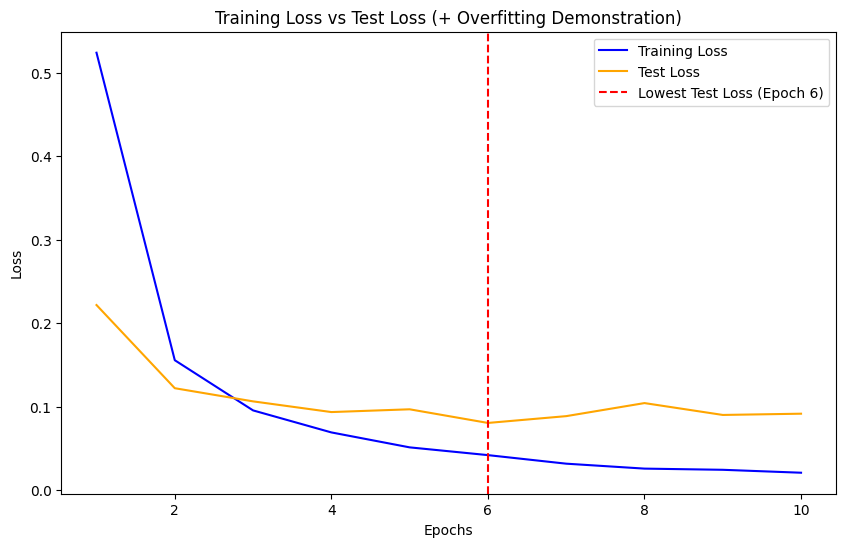

Test accuracy: 0.9788


In [6]:
### Train Network:
#Layer dimensions: Input (784), 3 hidden layers (256, 128, 64), Output (10)
layer_dims = [784, 256, 128, 64, 10]

# Train the network with Adam optimizer
parameters = train(X_train, y_train, X_test, y_test, layer_dims, learning_rate=0.001, batch_size=100, epochs=10)


### Try to Predict

# Predict on test data using forward_propagation function
Y_test_pred, _ = forward_propagation(X_test, parameters)

# Convert predictions to class labels
y_pred_classes = np.argmax(Y_test_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred_classes == y_true_classes)
print("Test accuracy:", accuracy)

Function to visualize some images and what the model predicts:

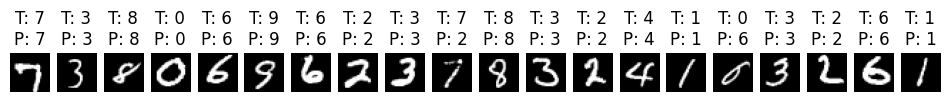

In [7]:
### Function to visualize the images and predictions

def visualize_predictions(X, Y, parameters, num_images=20):
    # Randomly select a few images from the dataset
    indices = np.random.choice(X.shape[0], num_images, replace=False)
    X_selected = X[indices]
    Y_true_selected = Y[indices]

    # Get the model's predictions for the selected images
    Y_pred_selected, _ = forward_propagation(X_selected, parameters)
    Y_pred_classes = np.argmax(Y_pred_selected, axis=1)
    Y_true_classes = np.argmax(Y_true_selected, axis=1)

    # Plot the images and predictions
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_selected[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        # Show true label and predicted label in the title
        plt.title(f"T: {Y_true_classes[i]}\nP: {Y_pred_classes[i]}")

    plt.show()

# Call the function to visualize predictions on training data
visualize_predictions(X_test, y_test, parameters, num_images=20)


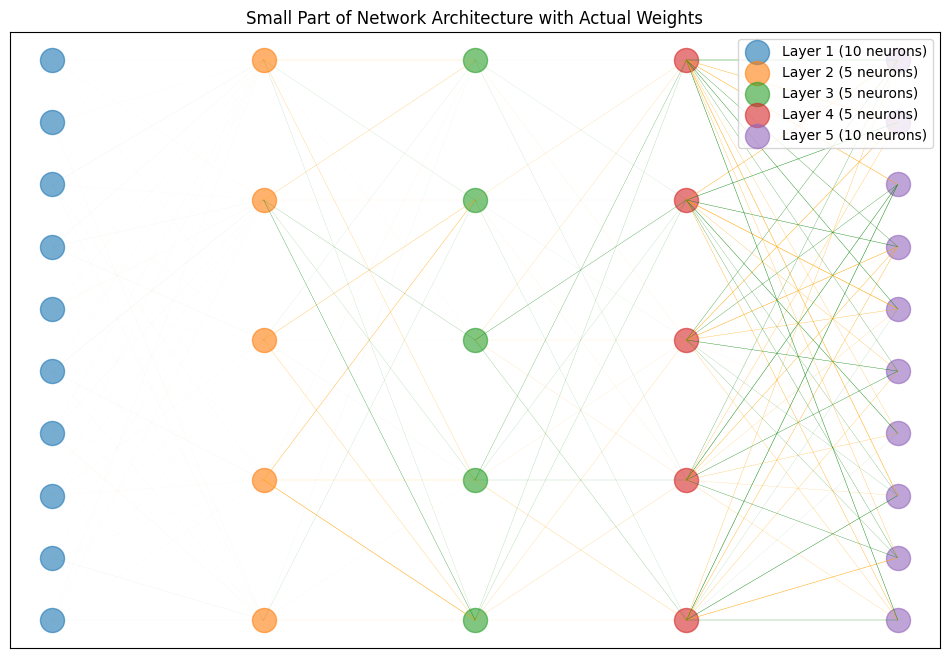

In [8]:
## Show part of the neural network just for fun

def plot_neural_network_with_actual_weights(layer_dims, parameters, num_neurons_to_show):

    fig, ax = plt.subplots(figsize=(12, 8))

    # Number of layers
    num_layers = len(num_neurons_to_show)

    # Positions for each layer
    layer_positions = np.linspace(0.1, 0.9, num_layers)

    # Loop through each layer to create neurons and connections
    for i in range(num_layers):
        # Plot neurons in the layer (subset)
        y = np.linspace(0.2, 0.8, num_neurons_to_show[i])  # Position of neurons in this layer
        x = np.full_like(y, layer_positions[i])  # X-axis position for this layer
        ax.scatter(x, y, s=300, label=f'Layer {i + 1} ({num_neurons_to_show[i]} neurons)', alpha=0.6)

        # Draw connections from this layer to the next with actual weights
        if i < num_layers - 1:
            next_y = np.linspace(0.2, 0.8, num_neurons_to_show[i + 1])  # Neuron positions in the next layer
            next_x = np.full_like(next_y, layer_positions[i + 1])

            # Get the corresponding weight matrix (subset for visualization)
            weight_matrix = parameters[f'W{i+1}'][:num_neurons_to_show[i], :num_neurons_to_show[i + 1]]

            # Visualize connections with weight magnitude
            for j, neuron in enumerate(zip(x, y)):
                for k, next_neuron in enumerate(zip(next_x, next_y)):
                    weight = weight_matrix[j, k]  # Weight between neuron j and neuron k
                    line_width = np.abs(weight) * 1  # Scale weight to line width (adjust for visibility)
                    color = 'green' if weight > 0 else 'orange'  # Positive weights in green, negative in orange
                    ax.plot([neuron[0], next_neuron[0]], [neuron[1], next_neuron[1]], color=color, lw=line_width)

    # Add title and labels
    ax.set_title('Small Part of Network Architecture with Actual Weights')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.legend(loc='upper right')
    plt.show()

# Example: Visualize part of the network with actual weights
layer_dims = [784, 256, 128, 64, 10]  # Full network dimensions
num_neurons_to_show = [10, 5, 5, 5, 10]  # Show a small subset of neurons

# Now, visualize using the actual parameters obtained after training
plot_neural_network_with_actual_weights(layer_dims, parameters, num_neurons_to_show)


Hi Prof

The above code has my neural network, a graph that shows the training & test loss after each epoch, as well as a red line that shows where test loss was lowest. The idea being that after that point, the model starts to overfit, as training loss falls, while test loss increases or fluctuates. Finally, i thought it would be fun to actually see some of the numbers, as well as what the model predicted and what the true label was, and i also added a visualization of what a small part of the network looks like.  

**The model has around 97.9% accuracy** after 10 epochs,  which means that most of the numbers are predicted correctly. Also, it can be seen from the chart that it **starts overfitting around epoch 6**.  

  

**Architecture:**
The network has 3 hidden layers, with both relu, selu and tanh, respectively, and then softmax for the output layer. Initially i started training it with normal gradient descent kind of like Trask (the medium article), before later implementing ADAM. That had a rather large impact on the number of epochs needed, as i needed like 50 before, while i only need around 5-10 now to see good accuracy and overfitting. My hyperparameter choices are mostly just what i could find is considered common practice for this problem.

I started with 128, 64 & 32 neurons in the hidden layers, but i could get a little lower test loss when actually using 256, 128 & 64 neurons, even though it does take a while longer to train. Weights are initialized random with a small number, and for the training rate, i tried going lower and higher, but i got the best result with 0,001. Batches are permutated so that they are randomized for training also.

I did try to also use a validation set, but the validation and the test loss was almost 1-1 identical at each epoch, so here only the test loss is shown. I think i should also mention that the training data is normalized. I did get quite high accuracy even without, but it does make it a bit better when its normalized.







